In [85]:
import gizmo_analysis as gizmo
import utilities as ut

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

from astropy import units as u
from astropy import constants as cst

from aqn import *
from constants import *

from itertools import product

In [2]:
# import FIRE m12i data cube
simulation_directory = 'FIRE/m12i_res7100'
part = gizmo.io.Read.read_snapshots('all', 'redshift', 0, simulation_directory)


# in utilities.simulation.Snapshot():
* reading:  FIRE/m12i_res7100/snapshot_times.txt

* input redshift = 0:  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  FIRE/m12i_res7100/output/snapdir_600/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 70514272 particles
    dark2     (id = 2): 5513331 particles
    gas       (id = 0): 57060074 particles
    star      (id = 4): 13976485 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['dark', 'dark2', 'gas', 'star']

* reading particles from:
    snapshot_600.0.hdf5
    snapshot_600.1.hdf5
    snapshot_600.2.hdf5
    snapshot_600.3.hdf5

* reading cosmological parameters from:  FIRE/m12i_res7100/initial_condition/ic_agora_m12i.conf

* checking sanity of particle properties

  cannot read file containing hosts coordinates
  instead will assign hosts via iterative zoom on particle mass

# in utilities.p

In [176]:
# define cube resolution parameters
cube_length       = 20
voxel_resolution  = 2**3

voxel_length = cube_length / voxel_resolution * u.kpc
voxel_volume = voxel_length**3

In [4]:
# create bins based on defined resolution parameters
bins = np.linspace(-cube_length/2,cube_length/2,voxel_resolution+1)
# bin center coordinates will be used to identify voxels
bin_centers = (bins[1:] + bins[:-1])/2
voxel_centers = np.array([bin_centers, bin_centers, bin_centers])

# create empty dictionaries for dark matter and gas components
dark_mat, neut_gas, ioni_gas = {}, {}, {}

In [5]:
# sort gas into neutral and ionized based on temperature
gas_temp = part['gas'].prop('temperature')
neutral_filter = gas_temp <  3e4
ionized_filter = gas_temp >= 3e4

# obtain coordinates of all particles within cube relative to Milky Way center
dark_mat["coords"] = part['dark'].prop('host.distance')
neut_gas["coords"] = part['gas'].prop('host.distance')[neutral_filter]
ioni_gas["coords"] = part['gas'].prop('host.distance')[ionized_filter]

dark_mat["within_cube"] = np.where((np.abs(dark_mat["coords"][:,0]) < cube_length/2) & 
                                   (np.abs(dark_mat["coords"][:,1]) < cube_length/2) &
                                   (np.abs(dark_mat["coords"][:,2]) < cube_length/2))
neut_gas["within_cube"] = np.where((np.abs(neut_gas["coords"][:,0]) < cube_length/2) & 
                                   (np.abs(neut_gas["coords"][:,1]) < cube_length/2) &
                                   (np.abs(neut_gas["coords"][:,2]) < cube_length/2))
ioni_gas["within_cube"] = np.where((np.abs(ioni_gas["coords"][:,0]) < cube_length/2) & 
                                   (np.abs(ioni_gas["coords"][:,1]) < cube_length/2) &
                                   (np.abs(ioni_gas["coords"][:,2]) < cube_length/2))

# obtain massses of all particles
dark_mat["masses"] = part['dark'].prop('mass')[dark_mat["within_cube"]]
neut_gas["masses"] = part['gas'].prop('mass')[neutral_filter][neut_gas["within_cube"]]
ioni_gas["masses"] = part['gas'].prop('mass')[ionized_filter][ioni_gas["within_cube"]]

# obtain velocities of all particles
dark_mat["v"] = part['dark'].prop('velocity')[dark_mat["within_cube"]]
neut_gas["v"] = part['gas'].prop('velocity')[neutral_filter][neut_gas["within_cube"]]
ioni_gas["v"] = part['gas'].prop('velocity')[ionized_filter][ioni_gas["within_cube"]]


In [193]:
# use histograms to obtain mass counts and velocities within each voxel
for dict in [dark_mat, neut_gas, ioni_gas]:
    print(".", end="")
    
    # bin all particle masses within cube, weighing by their mass
    dict["mass_count"], bin_edges, bin_numbers = stats.binned_statistic_dd(dict["coords"][dict["within_cube"]], 
                          dict["masses"], 
                          statistic='sum', 
                          bins=(bins,bins,bins),
                          expand_binnumbers=True)
    print("|", end="")
    
    # bin all particle velocities within cube, weighing by their mass
    velocities, bin_edges, bin_numbers = stats.binned_statistic_dd(dict["coords"][dict["within_cube"]], 
                          [dict["v"][:,0], dict["v"][:,1], dict["v"][:,2]]*dict["masses"], 
                          statistic='sum', 
                          bins=(bins,bins,bins),
                          expand_binnumbers=True, 
                          binned_statistic_result=None)

    # finish weighed average calculation
    velocities = velocities / dict["mass_count"]
    dict["v_x"], dict["v_y"], dict["v_z"] = velocities[0], velocities[1], velocities[2]

dv_neut = np.sqrt((dark_mat["v_x"] - neut_gas["v_x"])**2 + (dark_mat["v_y"] - neut_gas["v_y"])**2 + (dark_mat["v_z"] - neut_gas["v_z"])**2)
dv_ioni = np.sqrt((dark_mat["v_x"] - ioni_gas["v_x"])**2 + (dark_mat["v_y"] - ioni_gas["v_y"])**2 + (dark_mat["v_z"] - ioni_gas["v_z"])**2)
dv_neut, dv_ioni = (dv_neut * u.km/u.s).to(u.m/u.s), (dv_ioni * u.km/u.s).to(u.m/u.s)

.|.|.|

/tmp/ipykernel_422/2421944538.py:21: RuntimeWarning: invalid value encountered in divide
  velocities = velocities / dict["mass_count"]


In [206]:
# bin all ionized gas particle temperatures within cube, weighing by their mass
temperatures, bin_edges, bin_numbers = stats.binned_statistic_dd(ioni_gas["coords"][ioni_gas["within_cube"]], 
                      gas_temp[ionized_filter][ioni_gas["within_cube"]]*ioni_gas["masses"], 
                      statistic='sum', 
                      bins=(bins,bins,bins),
                      expand_binnumbers=True, 
                      binned_statistic_result=None)

ioni_gas["temperatures"] = temperatures / ioni_gas["mass_count"] * u.K

In [ ]:
# OLD #################################################################
# bin all particles within cube, weighing by their mass
# dark_mat["mass_count"], voxel_coords = np.histogramdd(dark_mat["coords"][dark_mat["within_cube"]], bins=(bins,bins,bins), 
#                                                       weights=dark_mat["masses"])
# neut_gas["mass_count"], voxel_coords = np.histogramdd(neut_gas["coords"][neut_gas["within_cube"]], bins=(bins,bins,bins), 
#                                                       weights=neut_gas["masses"])
# ioni_gas["mass_count"], voxel_coords = np.histogramdd(ioni_gas["coords"][ioni_gas["within_cube"]], bins=(bins,bins,bins), 
#                                                       weights=ioni_gas["masses"])

In [211]:
# calculate densities from mass counts
dark_mat["density"] = (dark_mat["mass_count"] * u.solMass).to(u.kg) / voxel_volume.to(u.m**3)
neut_gas["density"] = (neut_gas["mass_count"] * u.solMass).to(u.kg) / voxel_volume.to(u.m**3)
ioni_gas["density"] = (ioni_gas["mass_count"] * u.solMass).to(u.kg) / voxel_volume.to(u.m**3)

# we now have all of the data cubes we need:
# dark_mat["density"], neut_gas["density"], ioni_gas["density"], dv_neut, dv_ioni, ioni_gas["temperatures"]

In [ ]:
z_slice_min, z_slice_max = [-10,10]
mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
slice_count = np.sum(dark_mat["density"][:,:,mask], axis=2)

plt.figure(dpi=400)
plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
plt.colorbar(label='$\\rho_{DM}$  [kg/m$^3$]')
plt.xlabel('$x$ [kpc]')
plt.ylabel('$y$ [kpc]')
# plt.title("$\rho_{DM}$")
plt.title("$\\rho_{DM}$ in $z$-slice: ["+str(z_slice_min)+", "+str(z_slice_max)+"] kpc")
plt.show()

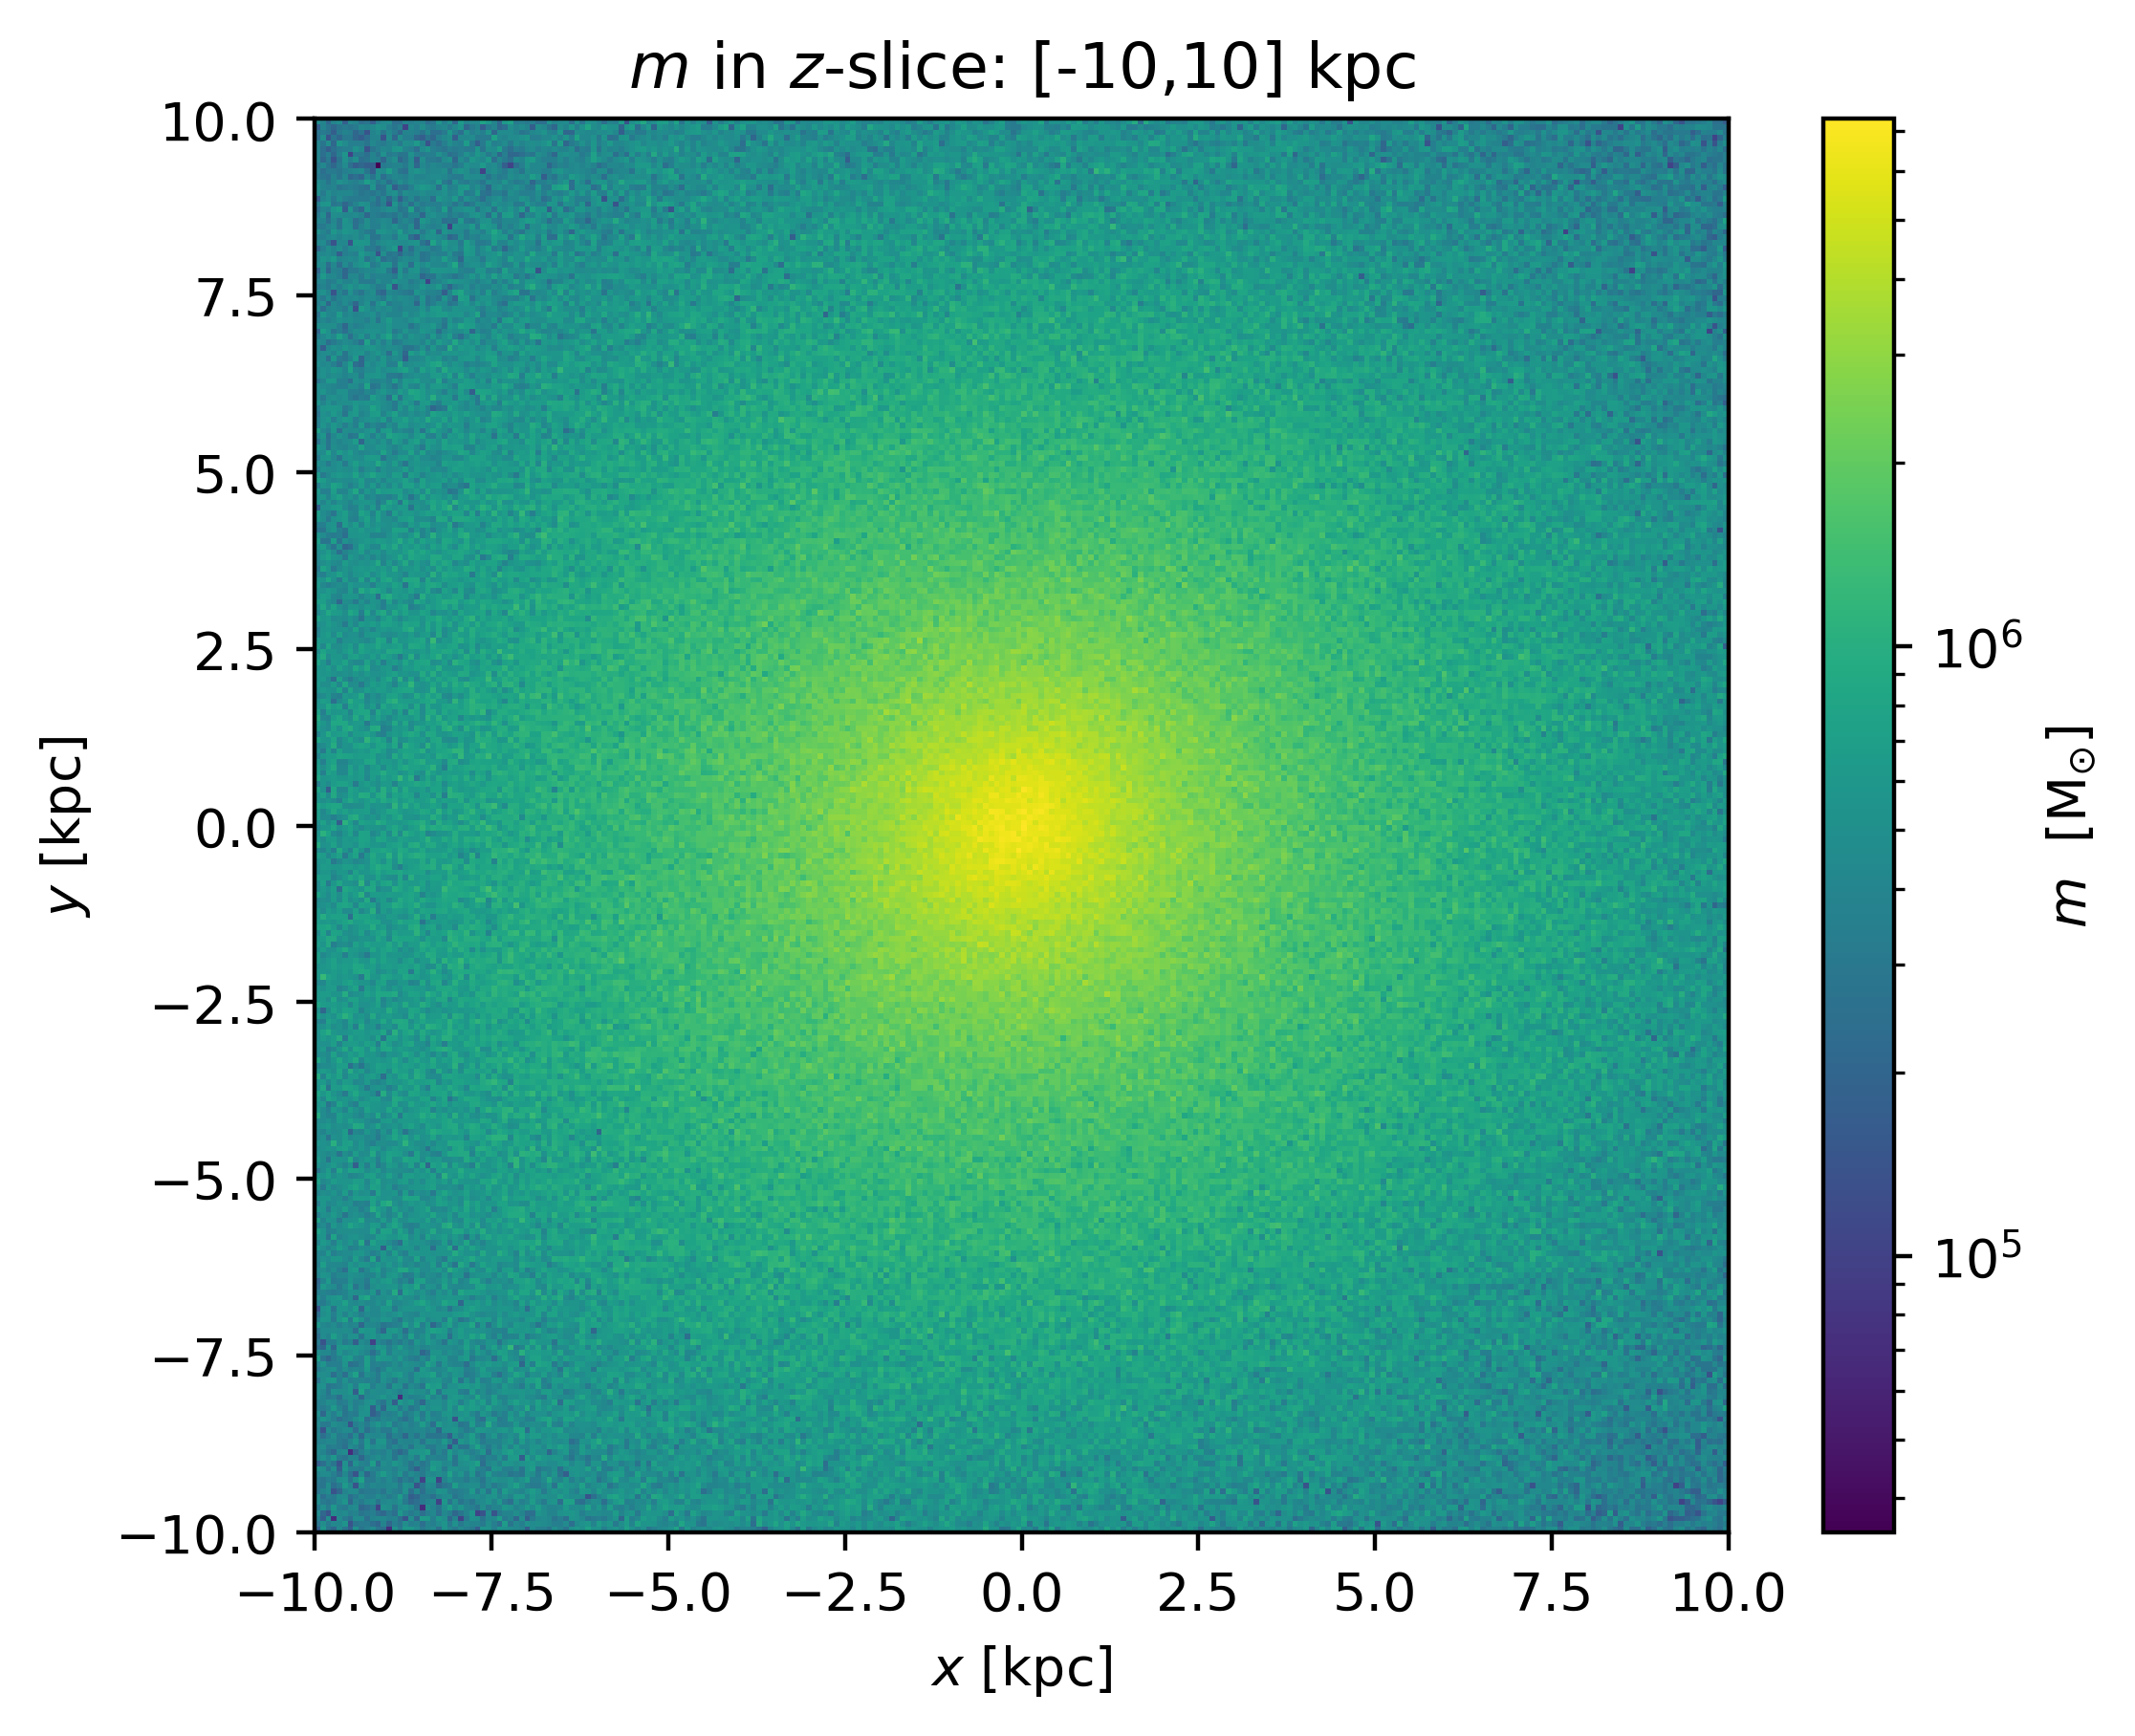

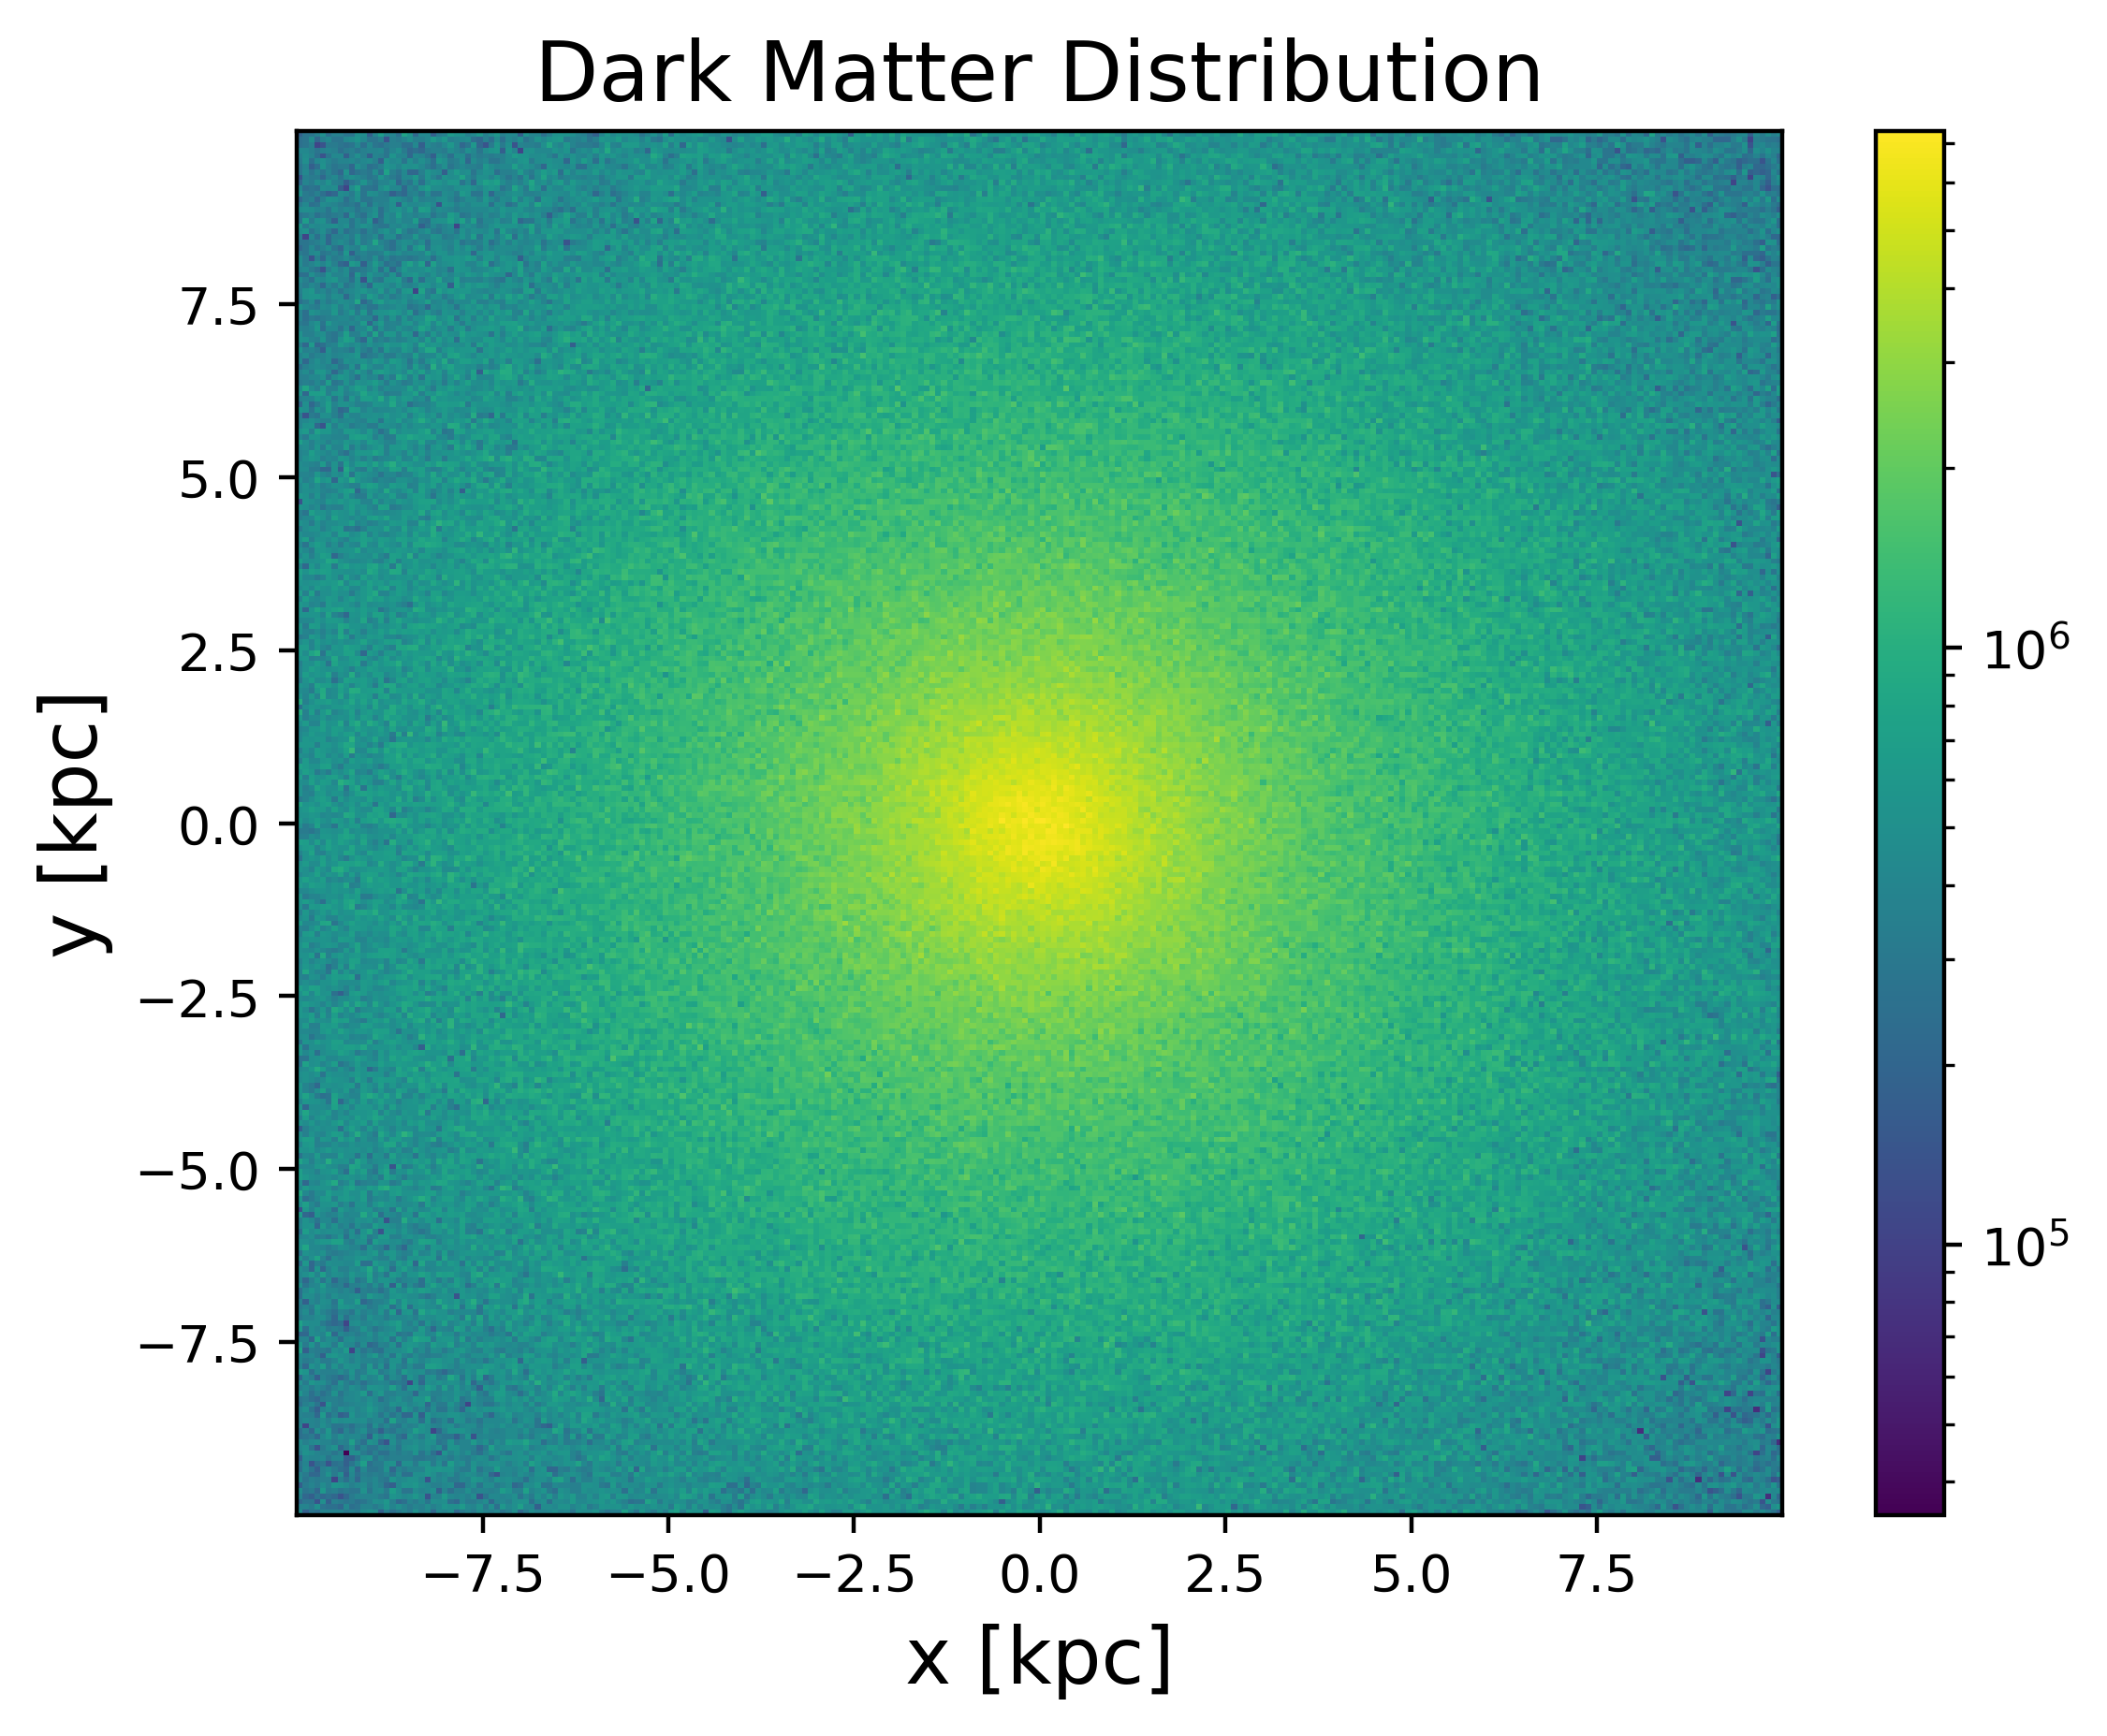

0.0


In [56]:
perform_sanity_check = True

if perform_sanity_check:
    z_slice_min, z_slice_max = [-10,10]
    mask = (voxel_coords[2] >= z_slice_min) & (voxel_coords[2] < z_slice_max)
    slice_count = np.sum(count[:,:,mask], axis=2)

    plt.figure(dpi=400)
    plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
    plt.colorbar(label='$m$  [M$_{\odot}$]')
    plt.xlabel('$x$ [kpc]')
    plt.ylabel('$y$ [kpc]')
    plt.title(f"$m$ in $z$-slice: [{z_slice_min},{z_slice_max}] kpc")
    plt.show()

    ##############################################################################

    within_cube = np.where((np.abs(coords[:,0]) < cube_length/2) & 
                           (np.abs(coords[:,1]) < cube_length/2) &
                           (np.abs(coords[:,2]) < cube_length/2))
    
    cube_coords = coords[within_cube]
    
    fig = plt.figure(dpi=400)
    ax = plt.gca()
    histo = ax.hist2d(cube_coords[:,0],
             cube_coords[:,1],
             bins = 256,
             norm = matplotlib.colors.LogNorm(), 
             weights = part['dark'].prop('mass')[within_cube])
    fig.colorbar(histo[3], ax=ax)

    ax.set_xlabel("x [kpc]",size=15)
    ax.set_ylabel("y [kpc]",size=15)
    ax.set_title("Dark Matter Distribution", size=16)

    plt.show()

    print(np.sum(slice_count - histo[0]))

In [213]:
# obtain the bins indexes that each particle belongs to -- consider avoiding using scipy.stats.binned_statistic_dd
# values can take a list of data types that you want to bin
# dark_mat["bin_indexes"] = []
# for i in range(len(voxel_coords)):
#     dark_mat["bin_indexes"].append(np.digitize(dark_mat["coords"][dark_mat["within_cube"]][:, i], voxel_coords[i]))
# dark_mat["bin_indexes"] = np.concatenate(dark_mat["bin_indexes"]).reshape(np.shape(dark_mat["coords"][dark_mat["within_cube"]])) - 1

# neut_gas["bin_indexes"] = []
# for i in range(len(voxel_coords)):
#     neut_gas["bin_indexes"].append(np.digitize(neut_gas["coords"][neut_gas["within_cube"]][:, i], voxel_coords[i]))
# neut_gas["bin_indexes"] = np.concatenate(neut_gas["bin_indexes"]).reshape(np.shape(neut_gas["coords"][neut_gas["within_cube"]])) - 1

# ioni_gas["bin_indexes"] = []
# for i in range(len(voxel_coords)):
#     ioni_gas["bin_indexes"].append(np.digitize(ioni_gas["coords"][ioni_gas["within_cube"]][:, i], voxel_coords[i]))
# ioni_gas["bin_indexes"] = np.concatenate(ioni_gas["bin_indexes"]).reshape(np.shape(ioni_gas["coords"][ioni_gas["within_cube"]])) - 1


# # create arrays for storing velocity components
# dark_mat["v_x"], dark_mat["v_y"], dark_mat["v_z"] = np.zeros([voxel_resolution]*3), np.zeros([voxel_resolution]*3), np.zeros([voxel_resolution]*3)
# neut_gas["v_x"], neut_gas["v_y"], neut_gas["v_z"] = np.zeros([voxel_resolution]*3), np.zeros([voxel_resolution]*3), np.zeros([voxel_resolution]*3)
# ioni_gas["v_x"], ioni_gas["v_y"], ioni_gas["v_z"] = np.zeros([voxel_resolution]*3), np.zeros([voxel_resolution]*3), np.zeros([voxel_resolution]*3)

# # calculate the average velocity in each bin, in each direction
# def obtain_velocity_components(dict):
#     for i in product(range(voxel_resolution), repeat=3):
#         x, y, z = i[0], i[1], i[2]
    
#         selected_particles = np.where((dict["bin_indexes"][:,0] == x) & (dict["bin_indexes"][:,1] == y) & (dict["bin_indexes"][:,2] == z))
        
#         if not len(dict["masses"][selected_particles]) == 0:
#             dict["v_x"][x,y,z] = np.average(dict["v"][selected_particles][:,0], weights = dict["masses"][selected_particles])
#             dict["v_y"][x,y,z] = np.average(dict["v"][selected_particles][:,1], weights = dict["masses"][selected_particles])
#             dict["v_z"][x,y,z] = np.average(dict["v"][selected_particles][:,2], weights = dict["masses"][selected_particles])
#         else:
#             dict["v_x"][x,y,z], dict["v_y"][x,y,z], dict["v_z"][x,y,z] = np.nan, np.nan, np.nan

# obtain_velocity_components(dark_mat)
# obtain_velocity_components(neut_gas)
# obtain_velocity_components(ioni_gas)

In [7]:
mass  = (np.average(part['dark'].prop('mass')) * u.solMass).to(u.kg)
m_aqn = 0.01 * u.kg

rho_dm = count * mass / voxel_volume.to(u.m**3) 
n_aqn = rho_dm / m_aqn

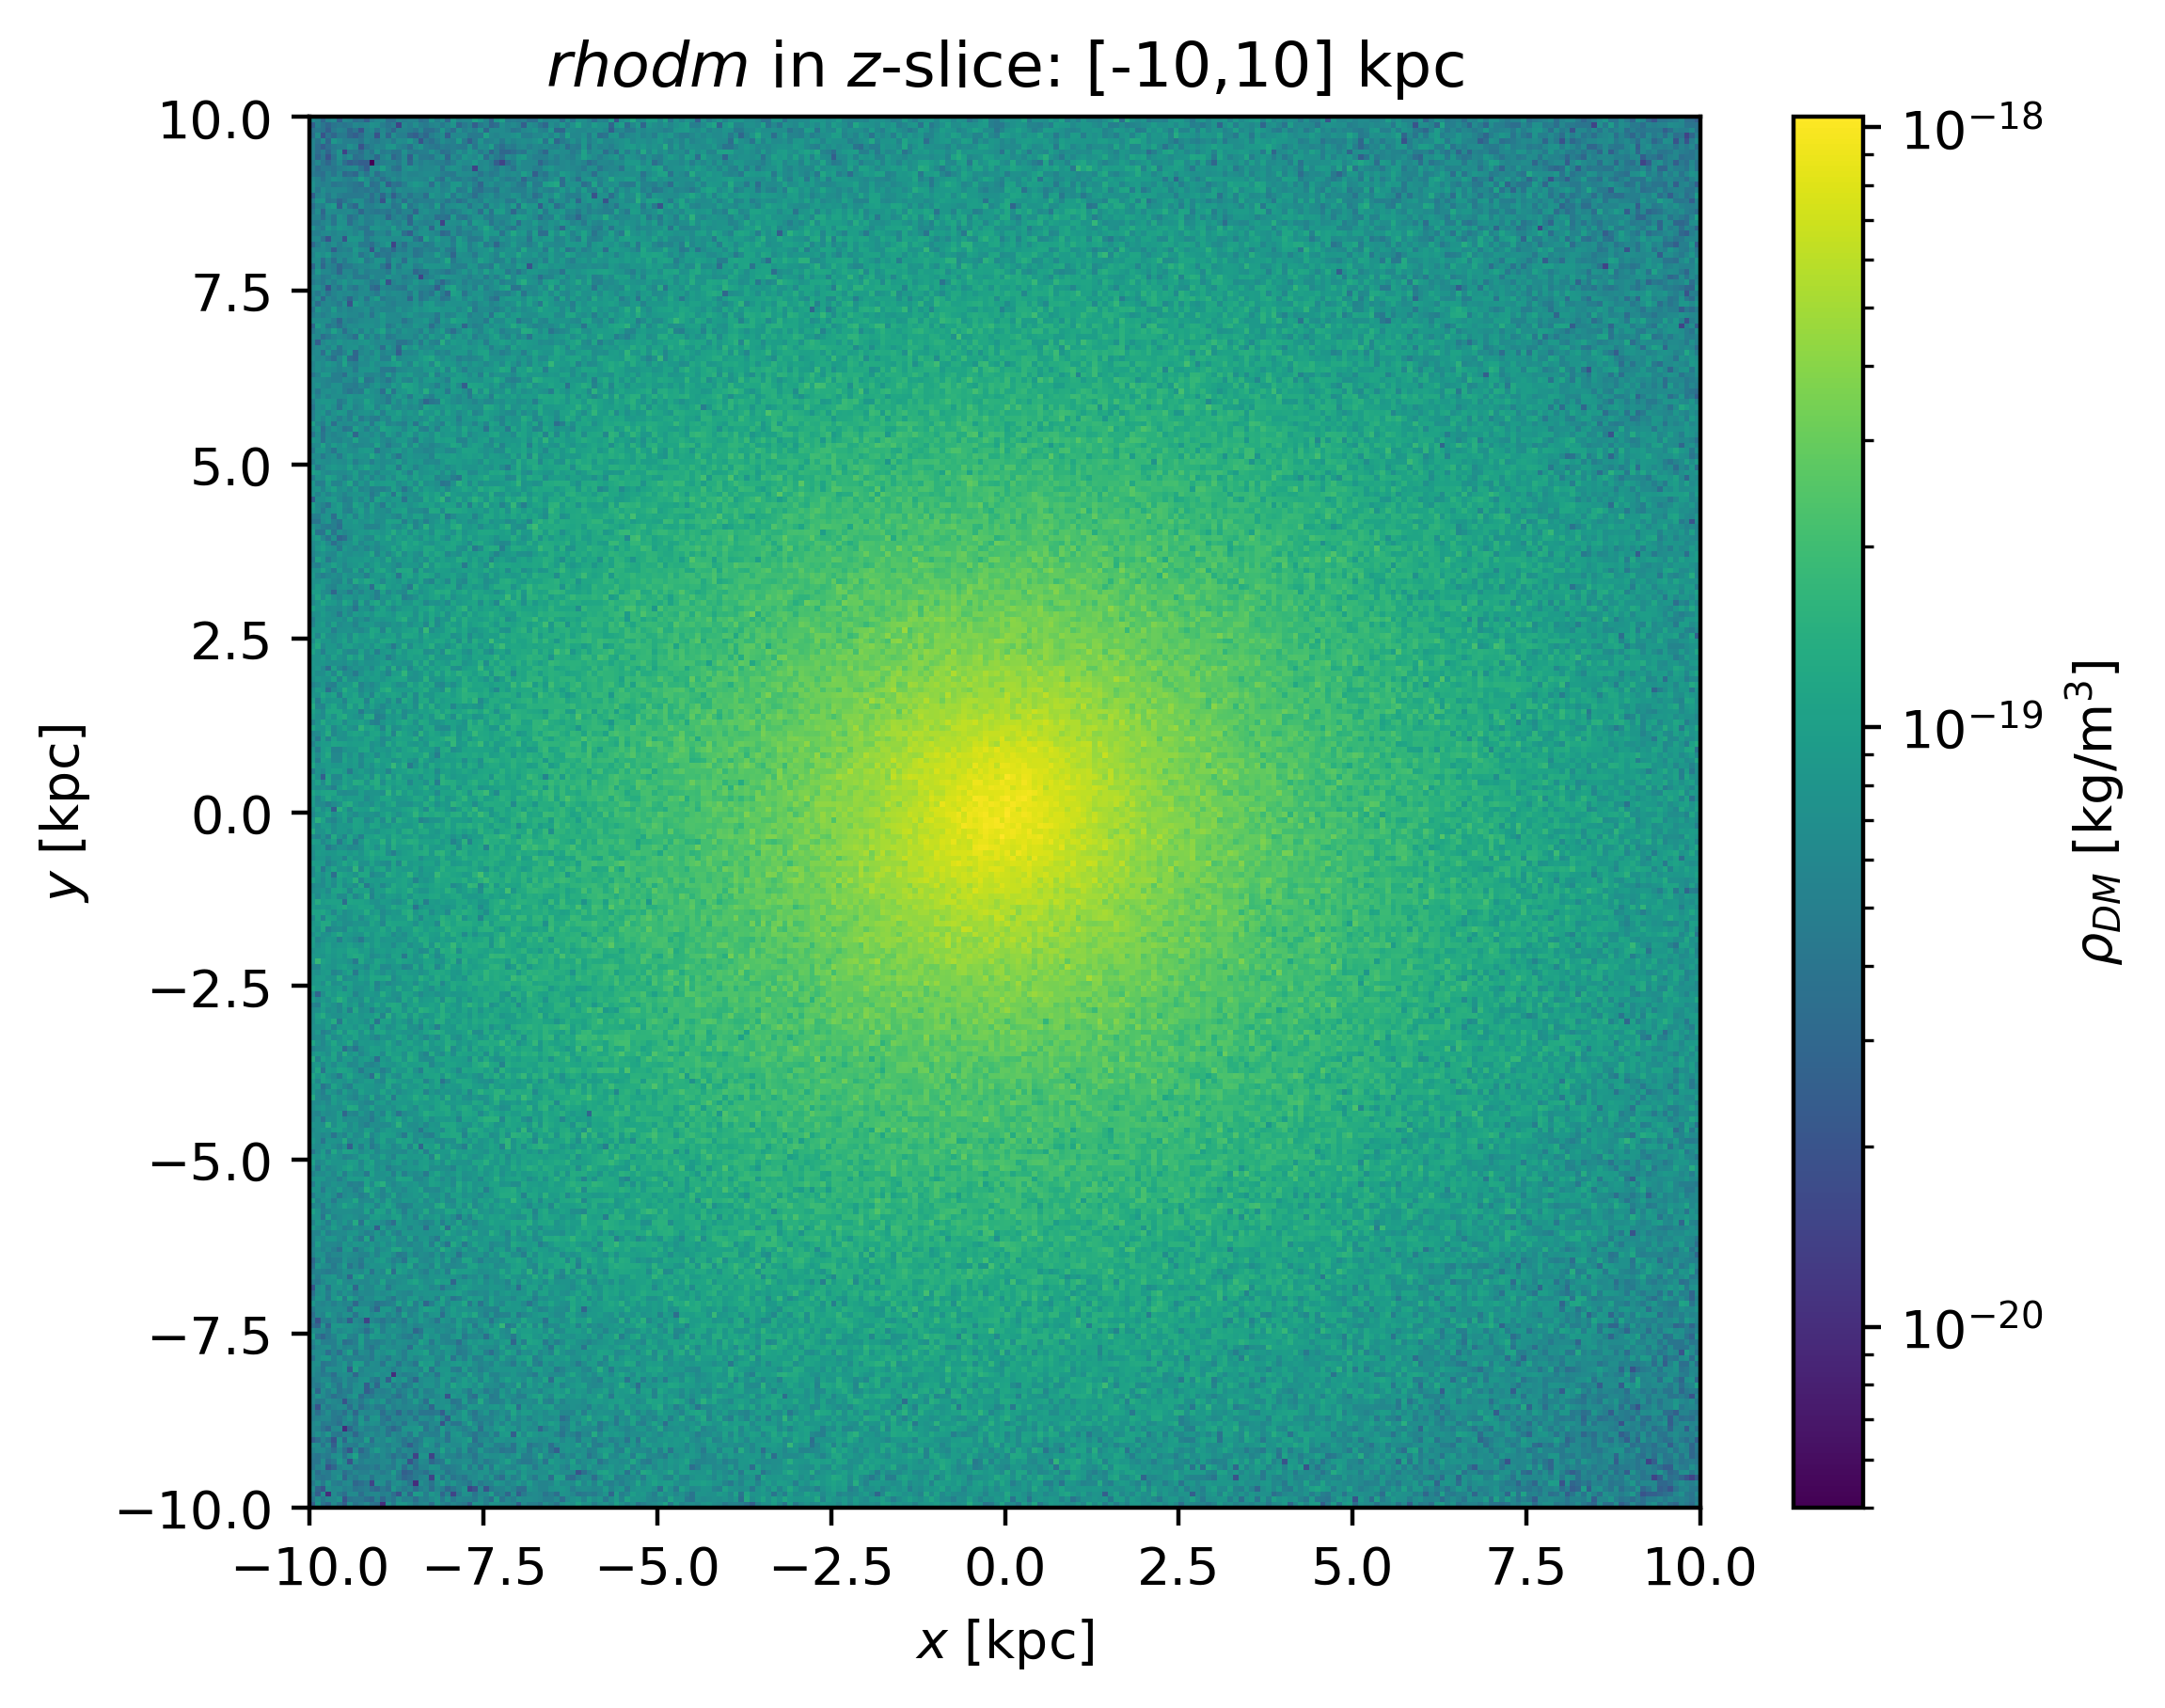

In [235]:
z_slice_min, z_slice_max = [-10,10]
mask = (voxel_coords[2] >= z_slice_min) & (voxel_coords[2] < z_slice_max)
slice_count = np.sum(rho_dm[:,:,mask], axis=2)

plt.figure(dpi=400)
plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
plt.colorbar(label='$\\rho_{DM}$ [kg/m$^3$]')
plt.xlabel('$x$ [kpc]')
plt.ylabel('$y$ [kpc]')
plt.title(f"$rhodm$ in $z$-slice: [{z_slice_min},{z_slice_max}] kpc")
# plt.title()
plt.show()

In [43]:
rho_dm2 = (count * u.solMass).to(u.kg) / voxel_volume.to(u.m**3)
print(np.sum(rho_dm2),np.sum(rho_dm))

9.645262630680807e-15 kg / m3 9.64537507940599e-15 kg / m3


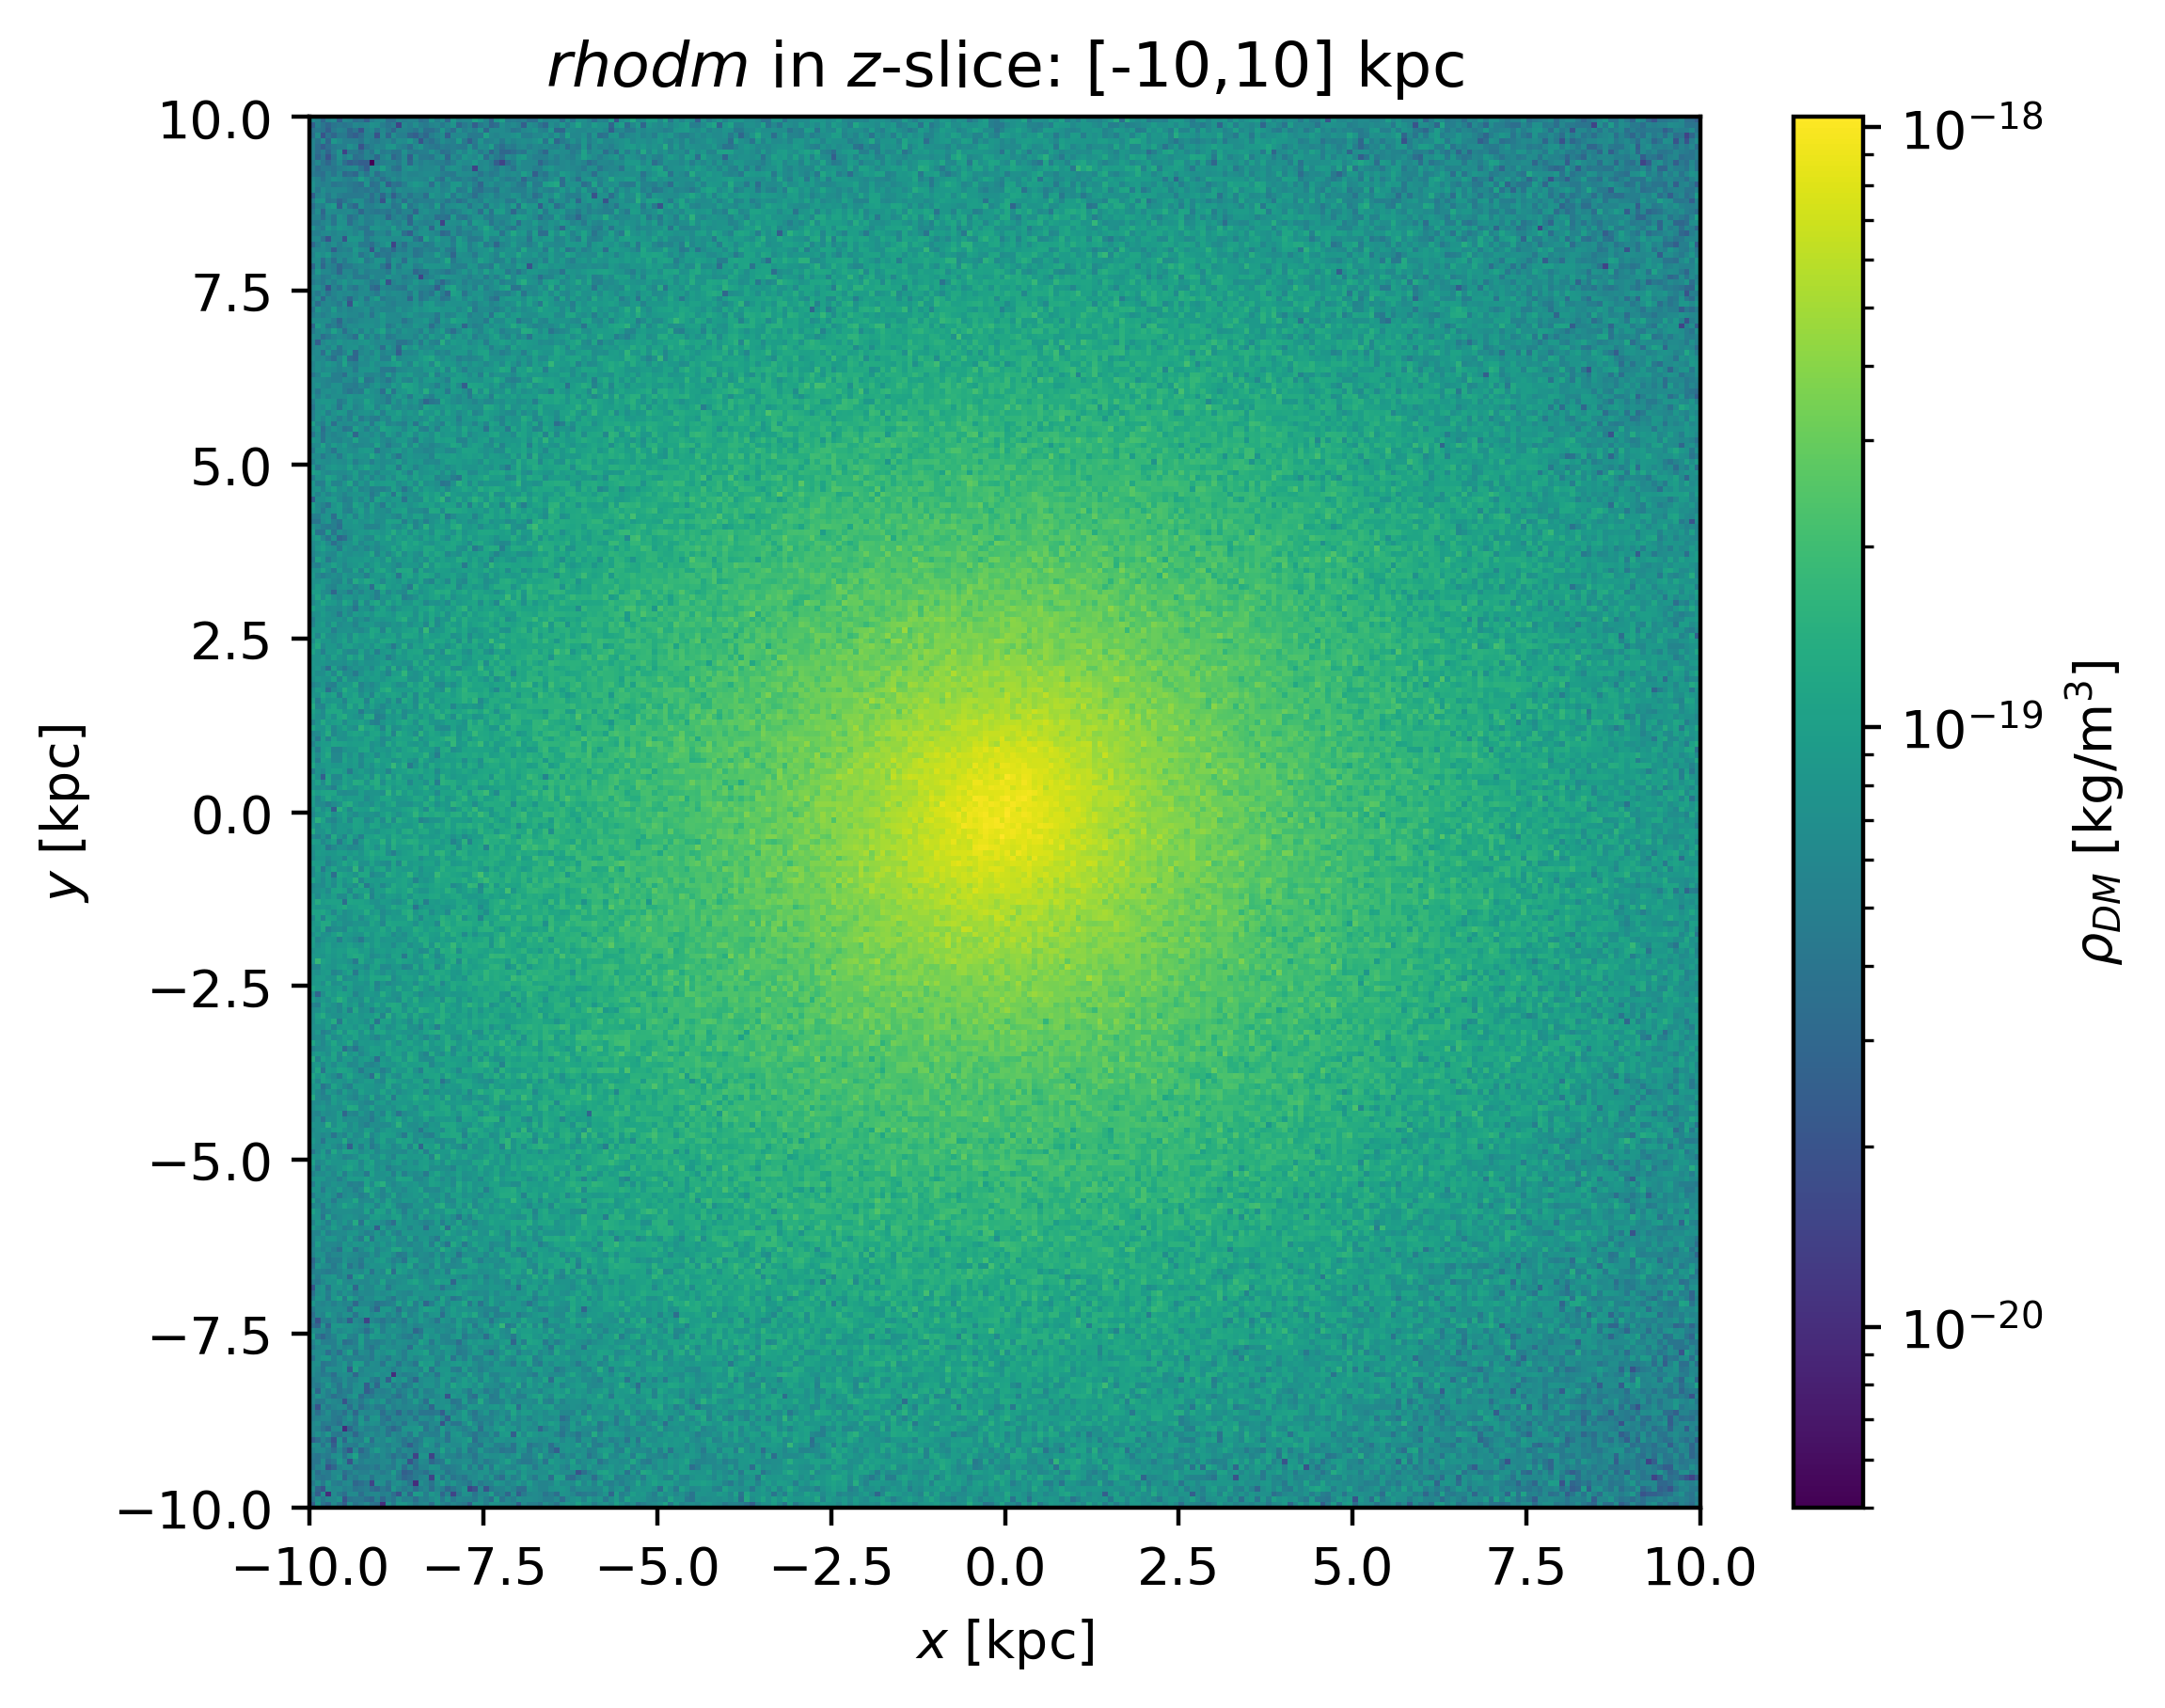

In [44]:
z_slice_min, z_slice_max = [-10,10]
mask = (voxel_coords[2] >= z_slice_min) & (voxel_coords[2] < z_slice_max)
slice_count = np.sum(rho_dm2[:,:,mask], axis=2)

plt.figure(dpi=400)
plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
plt.colorbar(label='$\\rho_{DM}$ [kg/m$^3$]')
plt.xlabel('$x$ [kpc]')
plt.ylabel('$y$ [kpc]')
plt.title(f"$rhodm$ in $z$-slice: [{z_slice_min},{z_slice_max}] kpc")
# plt.title()
plt.show()